<a href="https://colab.research.google.com/github/bork0047/Data-Analysis/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D0%B5_%D0%BD%D0%B0_TextAnalysis_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Analytics Part 2: Applying Machine Learning To Text Classification

This document covers the use of text preprocessing 
pipelines and parameter grids for text analysis. It also demonstrates how to create your own transformer to include in a pipeline and concludes with a comparative analysis of multiple machine learning algorithms on a text analysis problem. 

In [ ]:
import numpy as np
import pandas as pd

#for nlp
import nltk
from nltk.corpus import stopwords 
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

#text vectorisation
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

#metrics
from sklearn.metrics import classification_report, accuracy_score

#import method releated to evaluation
from sklearn import model_selection
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

#classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

#for graphs
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

#1. Text classification with IMDb movie review data

## Obtaining the IMDb movie review dataset

The IMDB movie review set can be downloaded from [http://ai.stanford.edu/~amaas/data/sentiment/](http://ai.stanford.edu/~amaas/data/sentiment/).
We have already done this and extracted the csv file which you can access from our github.  

In [ ]:
data_file = "https://raw.githubusercontent.com/nirmalie/CM4107/main/movie_data_cat.csv"
# class_index = 1 # on inspection of the csv file we see that the class appears in 1st position
df = pd.read_csv(data_file,  encoding='utf-8')
print('Shape:', df.shape)

df.head(10)  # top 10 rows

Shape: (50000, 2)


,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",pos
1,OK... so... I really like Kris Kristofferson a...,neg
2,"***SPOILER*** Do not read this, if you think a...",neg
3,hi for all the people who have seen this wonde...,pos
4,"I recently bought the DVD, forgetting just how...",neg
5,Leave it to Braik to put on a good show. Final...,pos
6,Nathan Detroit (Frank Sinatra) is the manager ...,pos
7,"To understand ""Crash Course"" in the right cont...",pos
8,I've been impressed with Chavez's stance again...,pos
9,This movie is directed by Renny Harlin the fin...,pos


## Preprocessing the movie dataset into more convenient format



Since the sentiment column happens to be categorical we can map the "pos" and "neg" classes to 0 and 1 integers. 

In [ ]:
class_mapping = {label:idx for idx,label in enumerate(np.unique(df['sentiment']))}

print("class_mapping:" , class_mapping)

#use the mapping dictionary to transform the class labels into integers
#the data frame series takes the mapping and applies it to each element in the series
#this mapping here acts like a replacement / subsititution (i.e. replace neg with 0 etc.)

df['sentiment'] = df['sentiment'].map(class_mapping)
df.head(10)

class_mapping: {'neg': 0, 'pos': 1}


,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0
3,hi for all the people who have seen this wonde...,1
4,"I recently bought the DVD, forgetting just how...",0
5,Leave it to Braik to put on a good show. Final...,1
6,Nathan Detroit (Frank Sinatra) is the manager ...,1
7,"To understand ""Crash Course"" in the right cont...",1
8,I've been impressed with Chavez's stance again...,1
9,This movie is directed by Renny Harlin the fin...,1


Now that the class column is as we need it for a classifier we next look at how to clean up the review text content. 

### Cleaning text data with Regular Expressions
Execute the code below to view a specific review. 
You will notice that the text needs cleaned up e.g. due to html markup, punctuation and other non-letter chars. 

In [ ]:
#import regular expressions to clean up the text
import re
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text) # remove all html markup ; re.sub(A, B, C) will Replace A with B in the string C.
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text) # findall the emoticons re.findall(A, B) | Matches all instances of an expression A in a string B and returns them in a list.
    
    # remove the non-word chars '[\W]+'
    # append the emoticons to end 
    # convert all to lowercase
    # remove horizontal nose char for consistency so that :-) is the same as :)
    text = (re.sub('[\W]+', ' ', text.lower()) +
            ' '.join(emoticons).replace('-', '')) 
    return text

### Stopwords, Tokenisation and Stemming 
We need to down load the stopwords list from nltk.
You can do that as follows:


In [ ]:
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer


nltk.download('stopwords')
#get the english stopwords
stop = set(stopwords.words('english'))
print("Number of stopwords:", len(stop))


Number of stopwords: 179


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Let's create  a method to stem each word / token contained in the piece of text. 
The text is first tokenised before stemming.

In [ ]:
#get the english stemmer
stemmer = SnowballStemmer("english")

def tokenizer(text):
       return text.split()
 

def tokenizer_stemmer(text):
    return [stemmer.stem(word) for word in tokenizer(text)]

### Get the Training and Testing splits

In [ ]:
#get a small sample from the 50K data
small_df= df.sample(frac=0.01, replace=False, random_state=1)
#Strip HTML and punctuation to speed up text processing
small_df['review'] = small_df['review'].apply(preprocessor)

#get the X and y parts of the data
X = small_df.loc[:, 'review'].values
y = small_df.loc[:, 'sentiment'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                          random_state=42,
                                                          test_size=0.30, # lets use 30% for testing
                                                          stratify=y)
print("Sample of Training data:", X_train.shape)
print("Sample of Test data:", X_test.shape)

Sample of Training data: (350,)
Sample of Test data: (150,)


### Convert dataset to vector representation

We use scikit-learn's `TfidfVectorizer` to convert the dataset to TF-IDF features for use by a machine learning algorithm.

In [ ]:
# initialise the vectorisers 
vectorizer_imdb = TfidfVectorizer(max_features=500)
vectorizer_imdb.fit(X) # Learn a vocabulary dictionary of all tokens in the raw documents.

# vectorise the train and test data
X_train_vec0 = vectorizer_imdb.transform(X_train)# transform to features for input into our classifier
X_test_vec0 = vectorizer_imdb.transform(X_test)
print("Sample of Training data:", X_train_vec0.shape)
print("Sample of Test data:", X_test_vec0.shape)

Sample of Training data: (350, 500)
Sample of Test data: (150, 500)


## <font color='red'>1.1 Exercise</font> Model for sentiment classification

Train a `LogisticRegression` model with default parameters using the vectorised dataset. Determine the training accuracy and the test accuracy.
Note: When you call `score` on classifiers like LogisticRegression, RandomForestClassifier, etc. the method computes the accuracy score by default (accuracy is #correct_preds / #all_preds). Therefore by default, the score method does not need the actual predictions. 

In [ ]:
## SOLUTION 1.1
# Train model

clf = LogisticRegression()# complete here to initialise the LogisticRegression classifier model

clf.fit(X_train_vec0, y_train) # complete here to fit the classifier

# Training accuracy
train_accuracy = clf.score(X_train_vec0, y_train)# complete here to get the train score from the classifier

# Test accuracy
test_accuracy = clf.score(X_test_vec0, y_test)# complete here to get the test score from the classifier

print("train accuracy:", train_accuracy)
print("test accuracy:", test_accuracy)

train accuracy: 0.9285714285714286
test accuracy: 0.74


#2. Building Pipelines and and using Grid Searches
In the above example we used the TF-IDF vectoriser to transform both the train and test data before fitting a classifier for prediction. 
This pipeline of transformation steps and the final prediction can be carried out by setting up a pipeline.

Instead of using the transformed vectors of X_train and Y_train ; we can use the original train and test which contained the text data i.e. X_train and X_test. 
These can then be sent through the transformation pipeline steps. 

## Form the train test splits

In [ ]:
small_df= df.sample(frac=0.01, replace=False, random_state=1)
X = small_df.loc[:, 'review'].values
y = small_df.loc[:, 'sentiment'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                          random_state=42,
                                                          test_size=0.30, # lets use 30% for testing
                                                          stratify=y)

## Build a Custom Transformer to preprocess the text (before vectorising)

Text clean-up to remove non-word characters (including HTML tags) from the text of movie reviews and convert to lowercase is one of the preprocessing steps that we used. This data preprocessing was achieved using our `preprocessor()`. Here, we convert the `preprocessor()` function to a tranformer to include in a pipeline using scikit-learn's FunctionTransformer. To demonstrate the use of parameters in the custom transformer, we include the ability to specify whether to convert the text to lowercase or not.

In [ ]:
#import sklearn's FunctionTransformer to create a transformer
from sklearn.preprocessing import FunctionTransformer

def text_cleanup(X, lowercase):  #lowercase: True to convert to lowercase or False to leave case as they are
    # print('in text_cleanup...')
    # print('lowercase:', lowercase)
    XX = np.copy(X)  # get copy of the data
    for index, text in enumerate(XX):
        text = re.sub('<[^>]*>', '', text) # remove all html markup ; re.sub(A, B, C) will Replace A with B in the string C.
        emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text) # findall the emoticons re.findall(A, B) | Matches all instances of an expression A in a string B and returns them in a list.
        
        # remove the non-word chars '[\W]+'
        # append the emoticons to end 
        # conditionally convert all to lowercase
        # remove nose char for consistency
        if lowercase:
            text = text.lower()
        text = (re.sub('[\W]+', ' ', text) +
                ' '.join(emoticons).replace('-', ''))
        XX[index] = text

    return XX

#creating text_cleanup object using FunctionTransformer
text_cleanup_preprocessor = FunctionTransformer(text_cleanup, kw_args={'lowercase': True})

## Specify and execute a Pipeline

Next, we include the custom transformer in the pipeline of transforms. We also include feature selection using chi-square.

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2

pipeline = make_pipeline(
                        text_cleanup_preprocessor,  # custom transformer for text cleanup
                        TfidfVectorizer(), # include the vectoriser
                        SelectKBest(chi2, k = 20),  # feature selection with chi-square using k best features
                        LogisticRegression(random_state=1, solver='lbfgs')
                        )

# SOLUTION here fit, predict and show the classification report

# add code here to fit the pipeline
pipeline.fit(X_train, y_train)

# predict 
y_pred = pipeline.predict(X_test)

# print just the test accuracy 
print('Test accuracy: %s' % pipeline.score(X_test, y_test))

# generate a classification report
class_labels = [k for k, v in class_mapping.items()]

#print(class_labels)
#print(class_mapping)
classification_report(y_test, y_pred, target_names=class_labels)
# add code here to get the predictions for the test set i.e. for y_pred

print(classification_report(y_test, y_pred, target_names=class_labels))

Test accuracy: 0.76
              precision    recall  f1-score   support

         neg       0.78      0.74      0.76        76
         pos       0.74      0.78      0.76        74

    accuracy                           0.76       150
   macro avg       0.76      0.76      0.76       150
weighted avg       0.76      0.76      0.76       150



## Setting up Grid Search
In the previous cell we calculated results based on a single test-train split. 
Ideally we want to do this using cross-validation. For this purpose we can use GridSearchCV.
Details of the many possible TfidfVectorizer parameters (see the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)). 

In [ ]:
param_grid0 = [{
    'clf__solver': [('lbfgs'), ('liblinear')],
    'vect__ngram_range': [(1,1)], #can also extract 2-grams of words in addition to the 1-grams (individual words)
    'vect__tokenizer': [tokenizer_stemmer], # use a tokeniser and the stemmer 
    'vect__stop_words': [stop, None], # try with and without the stop dictionary
    'tcp__kw_args': [{'lowercase': True}, {'lowercase': False}]  # case insensitive or not parameters for our custom transformer
  }]

#Sentiment classification with a neural net
pipe_tfidf = Pipeline([
                  ('tcp', text_cleanup_preprocessor),
                  ('vect', TfidfVectorizer()),
                  ('chi', SelectKBest(chi2, k = 20)),
                  ('clf', LogisticRegression())
  ])
                
gs_sentiment_classification = GridSearchCV(pipe_tfidf, param_grid0,
                           scoring='accuracy',
                           cv=5,
                           verbose=1,
                           n_jobs=1) 

#### <font color='red'>Warning</font>
**Important Note about the running time**

Executing the following code cell **may take up to 30-60 min** depending on your machine, since based on the parameter grid we defined, there are many models to fit.

If you do not wish to wait so long, you could reduce the size of the dataset by decreasing the number of training samples, for example, as follows:

    X_train = df.loc[:2500, 'review'].values
    y_train = df.loc[:2500, 'sentiment'].values
    
However, note that decreasing the training set size to such a small number will likely result in poorly performing models. Alternatively, you can delete parameters from the grid above to reduce the number of models to fit -- for example, by using the following:

    param_grid = [{'vect__ngram_range': [(1, 1)],
                   'vect__stop_words': [stop, None],
                   'vect__tokenizer': [tokenizer],
                  ]

In [ ]:
gs_sentiment_classification.fit(X_train, y_train) # Tfidf vectoriser will transform so send the X_train not the vectors

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'onc', 'onli', 'ourselv', "should'v", 'themselv', 'veri', 'whi', "you'r", "you'v", 'yourselv'] not in stop_words.
  % sorted(inconsistent)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'onc', 'onli', 'ourselv', "should'v", 'themselv', 'veri', 'whi', "you'r", "you'v", 'yourselv'] not in stop_words.
  % sorted(inconsistent)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor',

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tcp',
                                        FunctionTransformer(func=<function text_cleanup at 0x7fab91132c20>,
                                                            kw_args={'lowercase': True})),
                                       ('vect', TfidfVectorizer()),
                                       ('chi',
                                        SelectKBest(k=20,
                                                    score_func=<function chi2 at 0x7fab90fc1830>)),
                                       ('clf', LogisticRegression())]),
             n_jobs=1,
             param_grid=[{'clf__solver': ['lbfgs', 'liblinear'],
                          'tcp__kw_args': [{'lowe...
                          'vect__ngram_range': [(1, 1)],
                          'vect__stop_words': [{'a', 'about', 'above', 'after',
                                                'again', 'against', 'ain',
                                     

## <font color='red'>2.1 Exercise</font> Grid search for text classification
1. Once the gridsearchCV is complete; access the best_params_ and print it. Hint: refer to evaluation lab part 2 on using best_params_
2. use best_score_ to access the accuracy for the best parameter combination on the train set
3. use the best_estimator_ to make predictions on the unseen text data i.e. text_test. You can use gs_tfidf.best_estimator_.score(text_test, y_test) to calculate the accuracy on test.
4. Use classification_report() to provides a summary of performance on unseen test data. You need to get the predictions for the test data for this. 

In [ ]:
## SOLUTION 2.1
# 1. Best parameters
print(gs_sentiment_classification.best_params_)


{'clf__solver': 'lbfgs', 'tcp__kw_args': {'lowercase': True}, 'vect__ngram_range': (1, 1), 'vect__stop_words': {"don't", 'below', 'doing', 'over', 'that', 'haven', 'above', 'be', 'these', 'their', 'own', 'few', 'not', 'are', 'such', 'but', 'on', 'those', "wouldn't", 'with', 'if', "mightn't", 'am', 'didn', 'through', 'won', 'out', "you'll", 'while', "hasn't", 'as', 'at', 'after', 'just', 'by', 'against', 'o', 'hasn', "aren't", 'all', "she's", 'once', 'where', 'most', 'themselves', 'again', 'yourself', 'and', 'me', 'between', "that'll", 'y', 'a', 'more', 'into', 'myself', 'd', "haven't", 'too', 'down', 'theirs', 'of', 'is', 'why', 'you', 'for', 'when', 'we', 'very', 'hers', "couldn't", 'or', 'weren', 'ourselves', 't', 'been', 'mightn', 'they', 'who', 'were', 'can', 'had', 'how', 'during', 'does', 'now', "shouldn't", 'so', 'the', 'yourselves', 'him', 'them', 'our', 'm', "shan't", 'shouldn', 'having', 'nor', "you've", 'wouldn', "didn't", 'under', 'don', 'to', 'some', 'aren', "mustn't", 'ma

In [ ]:
# 2. Best score

gs_sentiment_classification.best_score_ 

0.7742857142857144

In [ ]:
# 3. Calculate the accuracy on the unseen text data using best_estimator_ and score

clf = gs_sentiment_classification.best_estimator_ 
clf.score(X_test, y_test)

0.76

In [ ]:
# 4. Performance summary on the test dataset using classification_report()
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=class_labels))

              precision    recall  f1-score   support

         neg       0.77      0.75      0.76        76
         pos       0.75      0.77      0.76        74

    accuracy                           0.76       150
   macro avg       0.76      0.76      0.76       150
weighted avg       0.76      0.76      0.76       150



####  GridSearchCV versus cross_val_score
    
Please note that **best_score_** is the average k-fold cross-validation score. I.e., if we have a `GridSearchCV` object with 5-fold cross-validation (like the one above), the `best_score_` attribute returns the average score over the 5-folds of the best model. 
In contrast cross_val_score will return the individual preformance values for each fold. 

In [ ]:
cross_val_score(gs_sentiment_classification, X_train, y_train, cv=5)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'onc', 'onli', 'ourselv', "should'v", 'themselv', 'veri', 'whi', "you'r", "you'v", 'yourselv'] not in stop_words.
  % sorted(inconsistent)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'onc', 'onli', 'ourselv', "should'v", 'themselv', 'veri', 'whi', "you'r", "you'v", 'yourselv'] not in stop_words.
  % sorted(inconsistent)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor',

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'onc', 'onli', 'ourselv', "should'v", 'themselv', 'veri', 'whi', "you'r", "you'v", 'yourselv'] not in stop_words.
  % sorted(inconsistent)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'onc', 'onli', 'ourselv', "should'v", 'themselv', 'veri', 'whi', "you'r", "you'v", 'yourselv'] not in stop_words.
  % sorted(inconsistent)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor',

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'onc', 'onli', 'ourselv', "should'v", 'themselv', 'veri', 'whi', "you'r", "you'v", 'yourselv'] not in stop_words.
  % sorted(inconsistent)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'onc', 'onli', 'ourselv', "should'v", 'themselv', 'veri', 'whi', "you'r", "you'v", 'yourselv'] not in stop_words.
  % sorted(inconsistent)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor',

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'onc', 'onli', 'ourselv', "should'v", 'themselv', 'veri', 'whi', "you'r", "you'v", 'yourselv'] not in stop_words.
  % sorted(inconsistent)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'onc', 'onli', 'ourselv', "should'v", 'themselv', 'veri', 'whi', "you'r", "you'v", 'yourselv'] not in stop_words.
  % sorted(inconsistent)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor',

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'onc', 'onli', 'ourselv', "should'v", 'themselv', 'veri', 'whi', "you'r", "you'v", 'yourselv'] not in stop_words.
  % sorted(inconsistent)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'onc', 'onli', 'ourselv', "should'v", 'themselv', 'veri', 'whi', "you'r", "you'v", 'yourselv'] not in stop_words.
  % sorted(inconsistent)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor',

array([0.81428571, 0.77142857, 0.82857143, 0.77142857, 0.68571429])

## <font color='red'>2.2 Exercise</font> Exploring text classifier alternatives with grid search
In the previous code you saw that having the stopword remover (i.e. stop) was better than None (not having stopword removal). You can now explore other alternatives. Change the param_grid0  values to explore the following:
1.  Does having Tokenizer_stemmer result in better accuracy compared to just the tokenizer (with no stemmer)?
2. What happens if you consider both unigrams and bigrams? Is there a benfit to analysing bigrams?
3. Include comparisons for different tfidf parameter values such as min_df (e.g. 7, 10, etc.), max_df (e.g. 0.75, 0.95, etc.), max_features (e.g. 500, 1000, or None)
4. How can you modify the classifier 'clf' to a different learner such as the 
NaiveBayes - MultinomialNB(alpha=1.0, class_prior=None) ; or any of the learners you have tried in the previous lab ; e.g.
MLPClassifier  - MLPClassifier(activation='relu', solver='adam', max_iter=2000, hidden_layer_sizes=(100,))  SVC(kernel='linear', gamma=0.7, C=1.0).

In [ ]:
#SOLUTION 2.2
param_grid22 = [{
    'clf__alpha': [(1.0)],
    'clf__class_prior': [(None)],
    'vect__ngram_range': [(1,1),(1,2)], #complete here to extract 2-grams of words in addition to the 1-grams (individual words)
    'vect__tokenizer': [stemmer, tokenizer_stemmer], #complete here for a tokeniser and the stemmer 
    'vect__stop_words': [stop, None], # try with and without the stop dictionary
    'vect__max_features': (500, 1000, None), #complete alternatives here for a vocabulary that only consider the top max_features ordered by term frequency
    'vect__min_df': (7, 10), #complete here for min_df i.e. ignore terms that have a document frequency strictly lower than )
    'vect__max_df': (0.75, 0.95), #ignore terms that have a document frequency strictly higher 
    'tcp__kw_args': [{'lowercase': True}, {'lowercase': False}]  # case insensitive or not parameters for our custom transformer
  }]

#Sentiment classification with a neural net
pipe_tfidf22 = Pipeline([
                  ('tcp', text_cleanup_preprocessor),
                  ('vect', TfidfVectorizer()),
                  ('chi', SelectKBest(chi2, k = 20)),
                  ('clf', MultinomialNB()) # complete code here

  ])
                
gs_sentiment_classification22 = GridSearchCV(pipe_tfidf22, param_grid22,
                           scoring='accuracy',
                           cv=5,
                           verbose=1,
                           n_jobs=1) 



In [ ]:
gs_sentiment_classification22.fit(X_train, y_train)
print('Best parameter set: %s ' % gs_sentiment_classification22.best_params_)
print('CV Accuracy: %.3f' % gs_sentiment_classification22.best_score_)

clf22 = gs_sentiment_classification22.best_estimator_
print('Test Accuracy: %.3f' % clf22.score(X_test, y_test))

Fitting 5 folds for each of 192 candidates, totalling 960 fits


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'onc', 'onli', 'ourselv', "should'v", 'themselv', 'veri', 'whi', "you'r", "you'v", 'yourselv'] not in stop_words.
  % sorted(inconsistent)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'onc', 'onli', 'ourselv', "should'v", 'themselv', 'veri', 'whi', "you'r", "you'v", 'yourselv'] not in stop_words.
  % sorted(inconsistent)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor',

Best parameter set: {'clf__alpha': 1.0, 'clf__class_prior': None, 'tcp__kw_args': {'lowercase': True}, 'vect__max_df': 0.95, 'vect__max_features': 1000, 'vect__min_df': 7, 'vect__ngram_range': (1, 1), 'vect__stop_words': None, 'vect__tokenizer': <function tokenizer_stemmer at 0x7fab91deb830>} 
CV Accuracy: 0.697
Test Accuracy: 0.633


## <font color='red'>2.3 Exercise</font> Exploring text classifier alternatives with grid search

Suppose we want to explore the impact of different chi squared feature selection subset sizes e.g. 50, 100, 200, 400, 700 on a NaiveBayes classifer. 

How can we set up such an experiment?
Note: you can set all the others to the best params from 2.2

In [ ]:
#SOLUTION 2.3
param_grid23 = [{

    'vect__ngram_range': [(1,1)], #can also extract 2-grams of words in addition to the 1-grams (individual words)
    'vect__tokenizer': [tokenizer_stemmer], # use a tokeniser and the stemmer 
    'vect__stop_words': [(None)], # try with and without the stop dictionary
    'vect__max_features': [(1000)], # a vocabulary that only consider the top max_features ordered by term frequency
    'vect__min_df': [(7)], # ignore terms that have a document frequency strictly lower than )
    'vect__max_df': [(0.95)], #ignore terms that have a document frequency strictly higher 
    'chi__k': [(50),(100), (200), (500)],
    'tcp__kw_args': [{'lowercase': True}]  # case insensitive or not parameters for our custom transformer
  }]

#Sentiment classification with a neural net
pipe_tfidf23 = Pipeline([
                  ('tcp', text_cleanup_preprocessor),
                  ('vect', TfidfVectorizer()),
                  ('chi', SelectKBest(chi2)),
                  ('clf',  MultinomialNB(alpha=1.0, class_prior=None))

  ])
                
gs_sentiment_classification23 = GridSearchCV(pipe_tfidf23, param_grid23,
                           scoring='accuracy',
                           cv=5,
                           verbose=1,
                           n_jobs=1)

In [ ]:
gs_sentiment_classification23.fit(X_train, y_train)
print('Best parameter set: %s ' % gs_sentiment_classification23.best_params_)
print('Best CV Accuracy: %.3f' % gs_sentiment_classification23.best_score_)

clf23 = gs_sentiment_classification23.best_estimator_
print('Best Accuracy on all Test data: %.3f' % clf23.score(X_test, y_test))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameter set: {'chi__k': 500, 'tcp__kw_args': {'lowercase': True}, 'vect__max_df': 0.95, 'vect__max_features': 1000, 'vect__min_df': 7, 'vect__ngram_range': (1, 1), 'vect__stop_words': None, 'vect__tokenizer': <function tokenizer_stemmer at 0x7fab91deb830>} 
Best CV Accuracy: 0.771
Best Accuracy on all Test data: 0.780


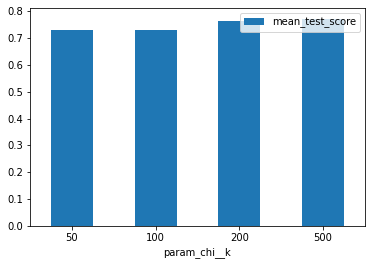

In [ ]:
cv_all_results_df = pd.DataFrame(gs_sentiment_classification23.cv_results_)
feature_selection_results = cv_all_results_df[["param_chi__k","mean_test_score"]]
feature_selection_results.plot.bar(y='mean_test_score', x="param_chi__k", rot=0)

# 3. Text Classification Case Studies 


## SMS spam filter

SMS Spam filter as a classification task. We first load the text data "SMSSpamCollection".

Furthermore, we perform some simple preprocessing and split the data array into two parts:

1. `text`: A list of lists, where each sublists contains the contents of our emails
2. `y`: our SPAM vs HAM labels stored in binary; a 1 represents a spam message, and a 0 represnts a ham (non-spam) message. 
1. Use the Tfidf vectoriser to transofrm the email content. 
2. Setup a gridsearch with pipelines to identify a good model for SMS message classification

NOTE: the class labels column is categorical. This means that we need a class mapping. 

In [ ]:
sms_filename = "https://raw.githubusercontent.com/nirmalie/CM4107/main/SMSSpamData.csv"
df_sms = pd.read_csv(sms_filename) 

In [ ]:
print("length of the dataset:", len(df_sms))
df_sms.head(10)

In [ ]:
# Get the classes mapped to 0 and 1
class_labels = (np.unique(df_sms['class'])) # get the unique class labels
print("Mapping class labels:", class_labels)
sms_class_mapping = {label:idx for idx,label in enumerate(class_labels)}

sms_class_labels = [x for x in sms_class_mapping] # store the class labels for later

df_sms["class"] = df_sms["class"].map(sms_class_mapping)
df_sms.head(3)

In [ ]:
# get the data
X = df_sms.loc[:, 'sms_msg'].values
y = df_sms.loc[:, 'class'].values
text_train, text_test, y_train, y_test = train_test_split(X, y, 
                                                          random_state=42,
                                                          test_size=0.30, # lets use 30% for testing
                                                          stratify=y)

small_df= df_sms.sample(frac=0.4, replace=False, random_state=1)

# form X and y
X = small_df.loc[:, 'sms_msg'].values
y = small_df.loc[:, 'class'].values
# get the split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                          random_state=42,
                                                          test_size=0.30, # lets use 30% for testing
                                                          stratify=y)
print("Sample of Training data:", X_train.shape)
print("Sample of Test data:", X_test.shape)

In [ ]:
# set the pipelines and grid search
param_grid_sms = [{
    'vect__ngram_range': [(1,2)], #can also extract 2-grams of words in addition to the 1-grams (individual words)
    'vect__tokenizer': [tokenizer_stemmer], # use a tokeniser and the stemmer 
    'vect__max_features': [1000, 4000], # set the vocabulary size'
    'vect__stop_words': [None] # use the stop dictionary of stopwords or not
              }]

#Sentiment classification with a neural net
pipe_tfidf_sms = Pipeline([
                  ('tcp', text_cleanup_preprocessor),       
                  ('vect', TfidfVectorizer( min_df=7)),  
                  ('chi', SelectKBest(chi2, k = 250)),    
                  ('cls', SVC(kernel='rbf', gamma=0.7, C=1.0)) # SVM classifier
                  ]) 
                
gs_sms_classification = GridSearchCV(pipe_tfidf_sms, param_grid_sms,
                           scoring='accuracy',
                           cv=5,
                           verbose=1,
                           n_jobs=1) 

In [ ]:
# fit the grid search 
gs_sms_classification.fit(X_train, y_train) 
print('Best parameter set: %s ' % gs_sms_classification.best_params_)
print('CV Accuracy: %.3f' % gs_sms_classification.best_score_)
clf = gs_sms_classification.best_estimator_

#use the test data to evaluate
print('Test Accuracy: %.3f' % clf.score(X_test, y_test))

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=class_labels))

## <font color='red'>3.1 Exercise</font> Carry out text classification on the Newsgroup dataset
The 20 newsgroups dataset comprises around 18000 newsgroups posts on 20 topics split in two subsets: one for training (or development) and the other one for testing (or for performance evaluation). The split between the train and test set is based upon a messages posted before and after a specific date.
You can find out more about the dataset from [sklearn dataset documentation](https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html)

Build a text classifier for this dataset by following these steps:
1.   Load the data an examine structure 
2.   Set the pipelines
3.   Specify the grid search
4.   Use GridSearchCV to determine the best model and parameters
5.   Analyse the result on the test data.



In [ ]:
#1. Load the data an examine structure

from sklearn.datasets import fetch_20newsgroups
from pprint import pprint

# please refer to sklearn documentation about the full dataset
# here we will work on a small sample of categories instead of the 20 categories
cats = ['sci.crypt','sci.electronics','sci.med','sci.space']
newsgroups_train = fetch_20newsgroups(subset='train', categories=cats)
newsgroups_test = fetch_20newsgroups(subset='test', categories=cats)

pprint(list(newsgroups_train.target_names))
news_class_labels = list(newsgroups_train.target_names)

In [ ]:
train_data= pd.Series(newsgroups_train.data) 


train_df=pd.DataFrame(train_data) 
train_df.columns = ['Data'] + train_df.columns.tolist()[1:] 
train_df['target'] = pd.Series(newsgroups_train.target)
print("Size of the corpus:", len(train_df))
train_df.head(8)

In [ ]:
# get the test data
test_data= pd.Series(newsgroups_test.data) 

test_df=pd.DataFrame(test_data) 
test_df.columns = ['Data'] + test_df.columns.tolist()[1:] # add the 'target' to the list of columns
test_df['target'] = pd.Series(newsgroups_test.target)

#Strip HTML and punctuation to speed up text processing
test_df['Data'] = test_df['Data'].apply(preprocessor)

print("Size of the test data:", len(test_df))
test_df.head(8)

In [ ]:
#get a small sample from the 50K data
small_df= train_df.sample(frac=0.5, replace=False, random_state=1)

X_train = small_df.loc[:, 'Data'].values
y_train = small_df.loc[:, 'target'].values


print("Sample of Training data:", X_train.shape)


#Test data
X_test = test_df.loc[:, 'Data'].values
y_test = test_df.loc[:, 'target'].values
print("Test data:", X_test.shape)

In [ ]:
# 2. Set pipline
news_pipe_tfidf = Pipeline([
    #complete code here

    ]) 


# 3. set the param grid
news_param_grid = [{
      #complete code here
  }]


In [ ]:
# 4. Fit the best model using GridSearchCV
gs_news_classification = GridSearchCV( ??, ?? # complete here
                          scoring='accuracy',
                          cv=5,
                          verbose=1,
                          n_jobs=1)

gs_news_classification.fit(X_train, y_train)
print('Best parameter set: %s ' % gs_news_classification.best_params_)
print('CV Accuracy: %.3f' % gs_news_classification.best_score_)

In [ ]:
# 5. Analyse the result on test data
news_clf = ?  # model from the best estimator

# detailed report on test data using classification_report
y_pred = ?
print(classification_report(?))

#4. Comparative study of multiple algorithms using the Sentiment 140 dataset

The sentiment140 dataset contains 1,600,000 tweets extracted using the twitter API. The tweets have been annotated (0 = negative, 2 = neutral, 4 = positive) and they can be used to detect sentiment.

https://www.kaggle.com/kazanova/sentiment140

In [ ]:
# download the zipped dataset to your colab files area and unzip it
!wget 'http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip'
!unzip trainingandtestdata.zip

In [ ]:
csv_file_name = "training.1600000.processed.noemoticon.csv"
df_senti140 = pd.read_csv(csv_file_name, header=None, encoding='latin-1')
df_senti140.columns =['target', 'id', 'date', 'flag', 'user', 'text']  # the dataset has no header so we add column names

df_senti140.head()

In [ ]:
df_senti140_small = df_senti140.sample(frac=0.01, replace=False, random_state=1)

#get the X and y parts of data
X = df_senti140_small.loc[:, 'text'].values
y = df_senti140_small.loc[:, 'target'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                          random_state=42,
                                                          test_size=0.30, # lets use 30% for testing
                                                          stratify=y)
print("Shape of Training data:", X_train.shape)
print("Shape of Test data:", X_test.shape)

In [ ]:
import copy


def gsearch(models, train_data, train_target, test_data, test_target, text_vectoriser, parameter_grid, scoring="accuracy", folds=5):
    """
    Performs grid searches for models and returns the training and test accuracies. 
    """
    dat = []
    ##iterate through each model
    for name, model, params in models:
        # add any model parameters to the parameter grid
        param_grid = copy.deepcopy(parameter_grid)  # deep copy so that 'parameter_grid' does not maintain a reference to 'param_grid'
        for param_name, param_options in params:
            param_grid[0]['model__' + param_name] = param_options

        # the pipeline
        pipe_tfidf = Pipeline([('clean', text_cleanup_preprocessor),
                               ('vector', text_vectoriser),
                               ('selector', SelectKBest(chi2, k = 800)),
                               ('model',  model)]) 
        
        # grid search cv
        gs_sentiment_classification = GridSearchCV(pipe_tfidf, param_grid,
                              scoring=scoring,
                              cv=folds,
                              verbose=1,
                              n_jobs=-1)
        
        gs_sentiment_classification.fit(train_data, train_target)

        print('Best parameter set: %s ' % gs_sentiment_classification.best_params_)
        train_score = gs_sentiment_classification.best_score_
        print('CV Accuracy: %.3f' % train_score)

        clf = gs_sentiment_classification.best_estimator_
        test_score = clf.score(test_data, test_target)
        print('Test Accuracy: %.3f\n' % test_score)
        dat.append([name, train_score, test_score])

    return pd.DataFrame(dat, columns=['Model', 'Train Accuracy', 'Test Accuracy'])

In [ ]:
# models
models = []
models.append(('LR', LogisticRegression(), [('max_iter', [100]), ('solver', [('lbfgs'), ('liblinear')]), ('multi_class', ['auto'])]))
models.append(('NB', MultinomialNB(alpha=1.0, class_prior=None), []))
models.append(('SVM', SVC(kernel='linear', gamma=0.1, C=1.0), []))

preprocess_param_grid = [{'vector__ngram_range': [(1, 1)], # ngram_range=(a,b) where a is the minimum and b is the maximum size of ngrams you want to include in your features
               'vector__stop_words': [stop, None], # use the stop dictionary of stopwords or not
               'vector__tokenizer': [tokenizer_stemmer]}, # use a tokeniser and the stemmer 
               ]

tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

plot_data = gsearch(models, X_train, y_train, X_test, y_test, tfidf, preprocess_param_grid)
print(plot_data)

In [ ]:
# plot grouped bar chart
plot_data.plot.bar(x='Model', ylim=(.5, 1.))